## Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
import rasterio as rio
from skimage.transform import rescale, resize
from skimage.morphology import binary_dilation,binary_closing, rectangle,disk, square, binary_erosion, binary_opening
from skimage.morphology import disk, erosion, dilation, reconstruction
from skimage.morphology import binary_dilation,binary_closing, rectangle,disk, square, binary_erosion, binary_opening
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, rectangle, disk, square, skeletonize
from skimage.filters import threshold_otsu,threshold_local,threshold_multiotsu
from scipy import ndimage as ndi
from sklearn import metrics
from scipy import misc,ndimage
from skimage.morphology import skeletonize,dilation
from scipy.stats import boxcox
from skimage.segmentation import watershed
from skimage import (filters, measure, morphology, segmentation)
import math
import pandas as pd

## Helper Functions

In [2]:
def seed_2(CHM, centroids, patch_size):
    top_seeds = []
    for i in centroids:
        loc0 = i[0]-round(patch_size/2)
        loc1 = i[1]-round(patch_size/2)
        loc0_a = loc0
        loc0_b = loc0+patch_size
        loc1_a = loc1
        loc1_b = loc1+patch_size
        
        if loc0_a<0:
            loc0_a = 0
            loc0_b = loc0_a + patch_size
        elif loc0_b > CHM.shape[0]:
            loc0_b = CHM.shape[0]
            loc0_a = loc0_b - patch_size
            
        if loc1_a<0:
            loc1_a = 0
            loc1_b = loc1_a + patch_size
        elif loc1_b > CHM.shape[1]:
            loc1_b = CHM.shape[1]
            loc1_a = loc1_b - patch_size
        
        loc0_a = int(loc0_a)
        loc0_b = int(loc0_b)
        loc1_a = int(loc1_a)
        loc1_b = int(loc1_b)
        
        high_pixel_intensity = 0       
        for r in range(loc0_a,loc0_b):
            for s in range(loc1_a,loc1_b):
                if CHM[r,s] > high_pixel_intensity:
                    high_pixel_intensity = CHM[r,s]
                    index = [r,s]
                
        top_seeds.append(index)
        
    
    seed_2 = np.array(top_seeds)
    
    return seed_2

In [3]:
def new_cod(CHM, centroids, patch_size):
    cent = []
    for i in range(len(centroids)):
        cent.append(list(centroids[i]))
 
    for i in centroids:
        if list(i) in cent:
            
            loc0 = i[0]-round(patch_size/2)
            loc1 = i[1]-round(patch_size/2)
            loc0_a = loc0
            loc0_b = loc0+patch_size
            loc1_a = loc1
            loc1_b = loc1+patch_size

            if loc0_a<0:
                loc0_a = 0
                loc0_b = loc0_a + patch_size
            elif loc0_b > CHM.shape[0]:
                loc0_b = CHM.shape[0]
                loc0_a = loc0_b - patch_size

            if loc1_a<0:
                loc1_a = 0
                loc1_b = loc1_a + patch_size
            elif loc1_b > CHM.shape[1]:
                loc1_b = CHM.shape[1]
                loc1_a = loc1_b - patch_size

            loc0_a = int(loc0_a)
            loc0_b = int(loc0_b)
            loc1_a = int(loc1_a)
            loc1_b = int(loc1_b)

            L = []
            high_pixel_intensity = 0

            for r in range(loc0_a,loc0_b):
                for s in range(loc1_a,loc1_b):
                    for z in range(len(cent)):
                        if (cent[z] == [r,s]):
                            L.append([r,s])
            for l in L:
                if CHM[l[0],l[1]] > high_pixel_intensity:
                    high_pixel_intensity = CHM[l[0],l[1]]
                    index = l
                    
            L.remove(index)
            for c in L:
                if c in cent:
                    cent.remove(c)
    cent = np.array(cent)
    return cent

# Tree Top Detection

### Step 1: Importing Middle layer DSM

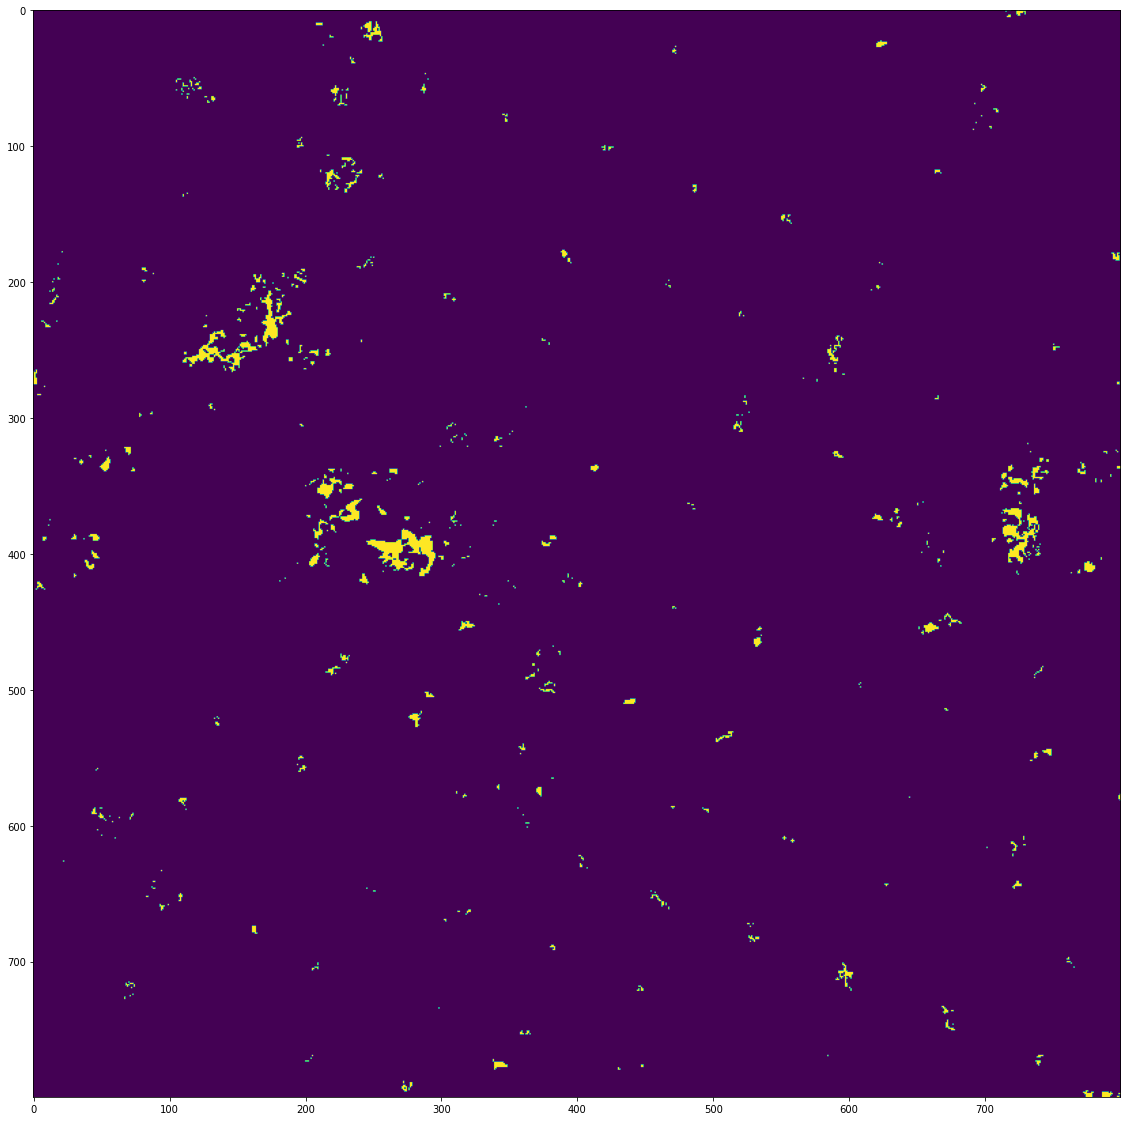

In [5]:
src_mid = rio.open('/Users/vidhanjain/opt/anaconda3/envs/skimage_cv2/plot3/plot3_dsmmid555_realign.tif')
data_mid=src_mid.read(1)
data_mid1 = data_mid[300:1100,600:1400]
img_mid1 = (data_mid1>554)*1
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img_mid1)

### Step 2: Applying Binary Morphological Operations

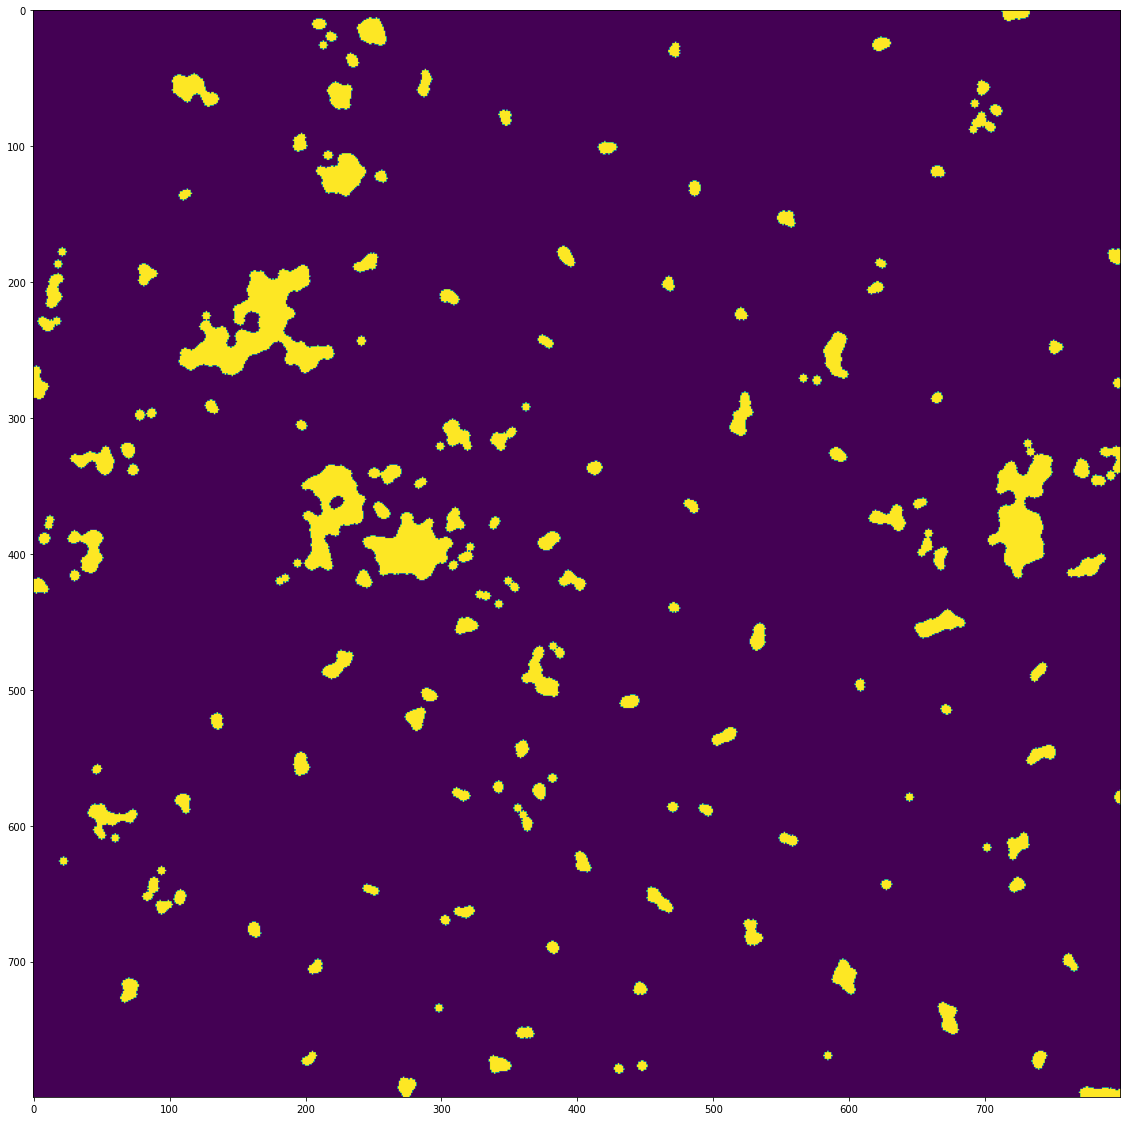

In [6]:
close=binary_closing(img_mid1,disk(6))
final=binary_dilation(close, disk(3))
plt.imshow(final)

### Step 3: Finding Centroid of every object in the image

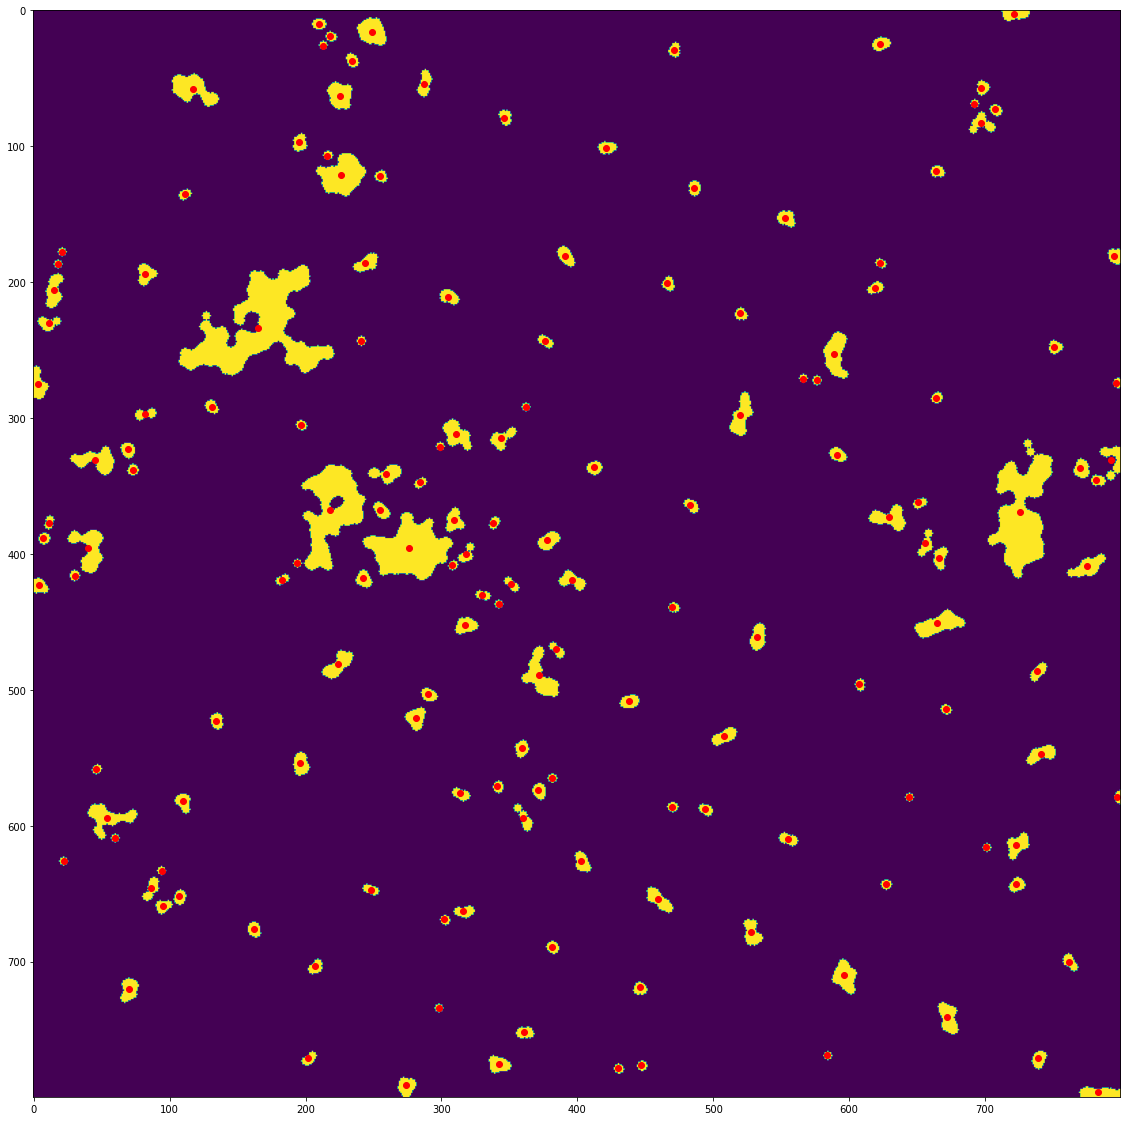

In [7]:
label_image = measure.label(final,connectivity=img_mid1.ndim)
props_table = regionprops_table(label_image,intensity_image=img_mid1, properties=['centroid'])
df = pd.DataFrame(props_table)
centroids = df.values
centroids = centroids.astype('int')

plt.imshow(final)
plt.plot(centroids[:, 1], centroids[:, 0], 'ro')

### Step 4: Take top layer CHM and smooth the image

In [8]:
'''DTM of a plot'''
src_dtm = rio.open('/Users/vidhanjain/opt/anaconda3/envs/skimage_cv2/plot3/plot3_dtm_realign.tif')
data_dtm=src_dtm.read(1)

'''DSM of a plot top layer'''
src_top = rio.open('/Users/vidhanjain/opt/anaconda3/envs/skimage_cv2/plot3/plot3_dsmtop_realign.tif')
data_top=src_top.read(1)

In [9]:
chm = data_top-data_dtm
for i in range(chm.shape[0]):
    for j in range(chm.shape[1]):
        if chm[i][j] < 0:
            chm[i][j] = 0
        if chm[i][j] >30:
            chm[i][j] = 0

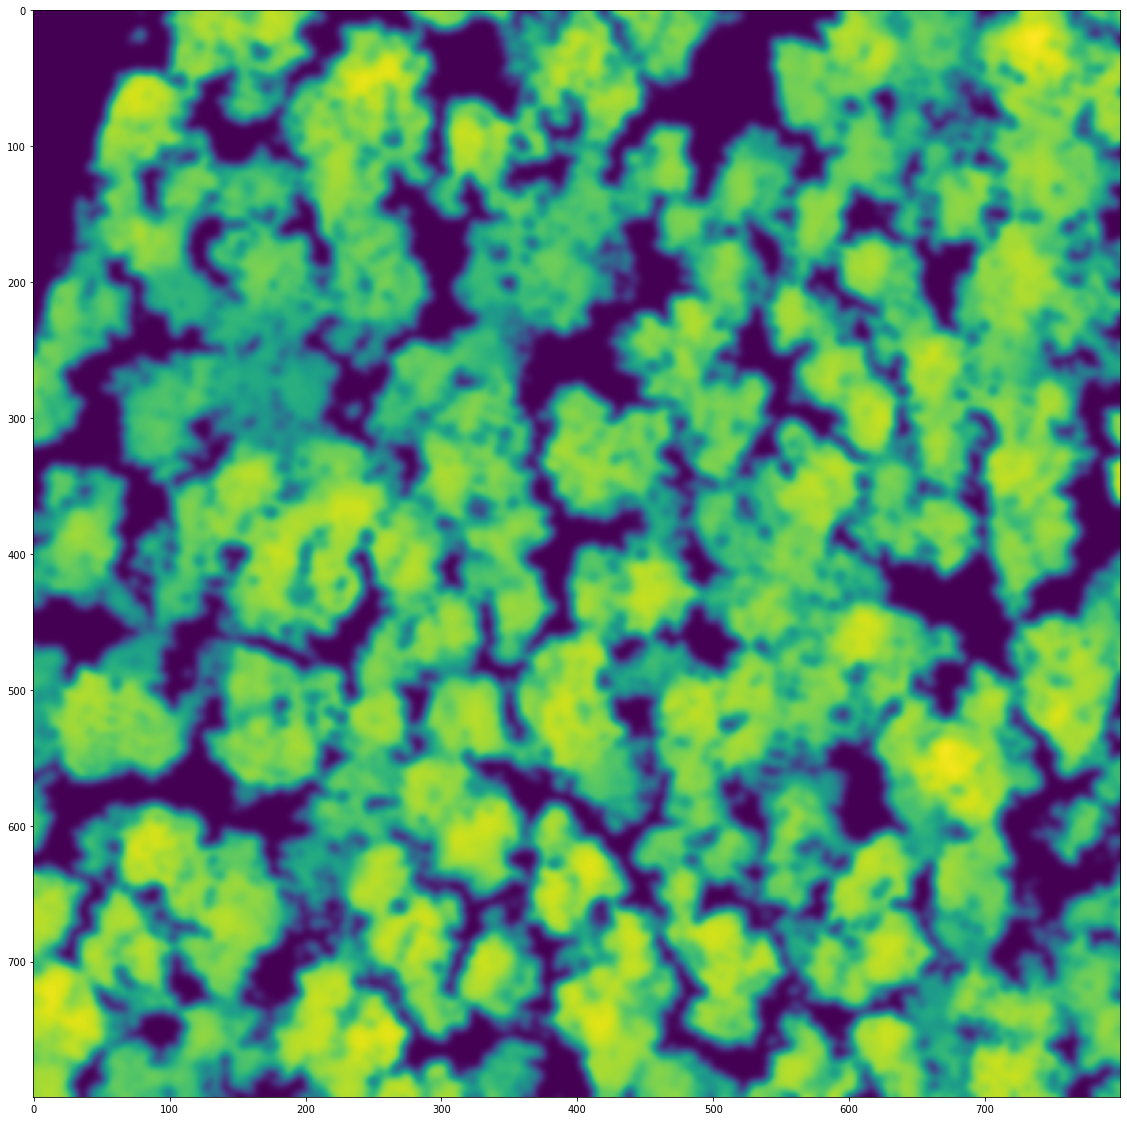

In [10]:
data_top = chm[300:1100,600:1400]
data_top = (data_top>7)*data_top
img_median = filters.median(data_top)
img_gauss = filters.gaussian(img_median,sigma=3)
plt.imshow(img_gauss)

### Step 5: Overlap centroids on the top layer CHM

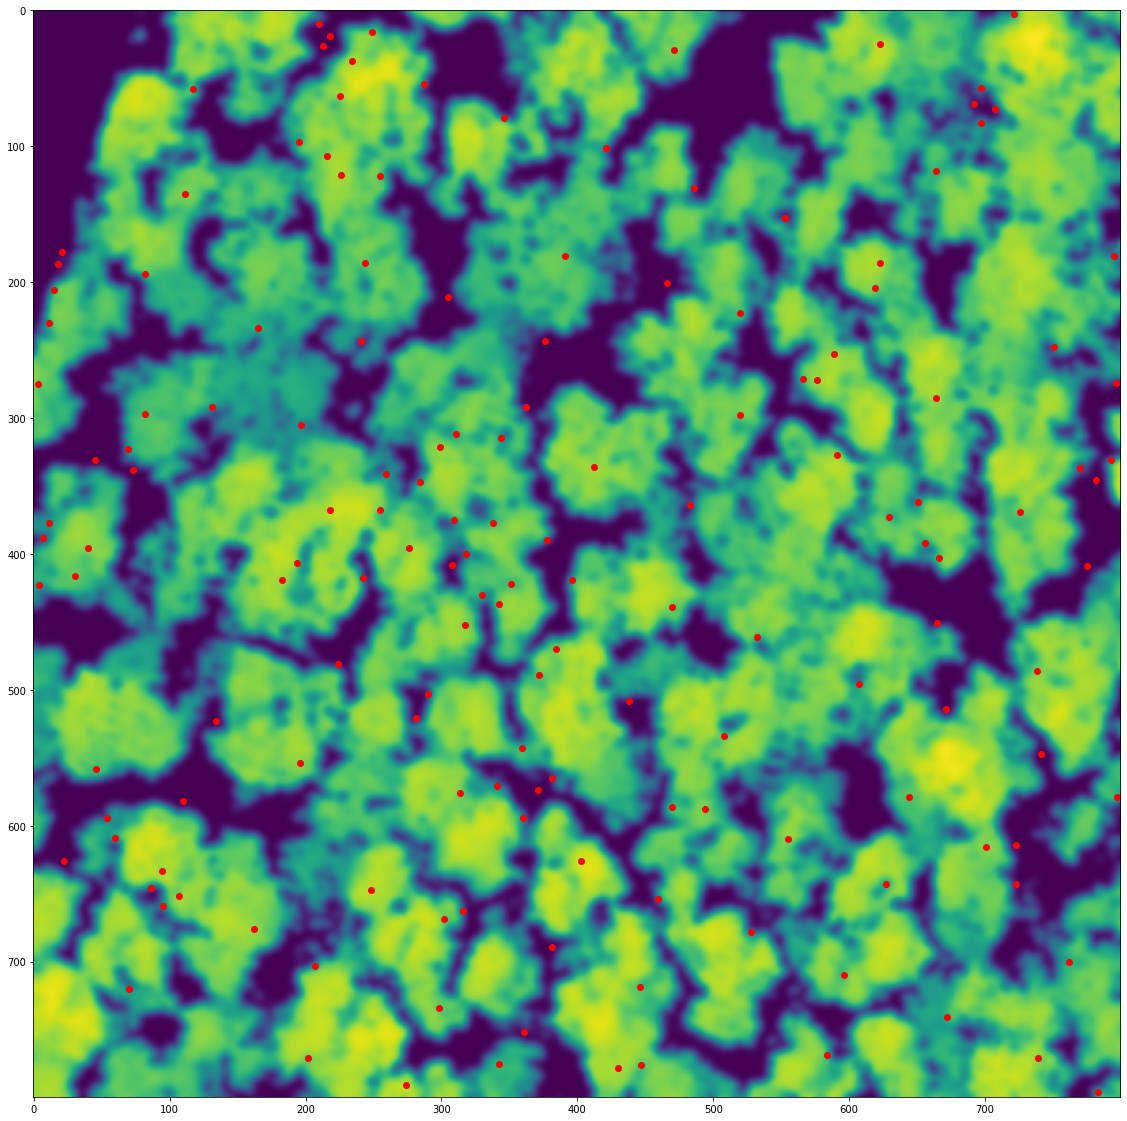

In [11]:
plt.imshow(img_gauss)
plt.plot(centroids[:, 1], centroids[:, 0], 'ro')

### Step 6: Make a window around each centroid and find the highest intensity pixel in that window(seed_2)

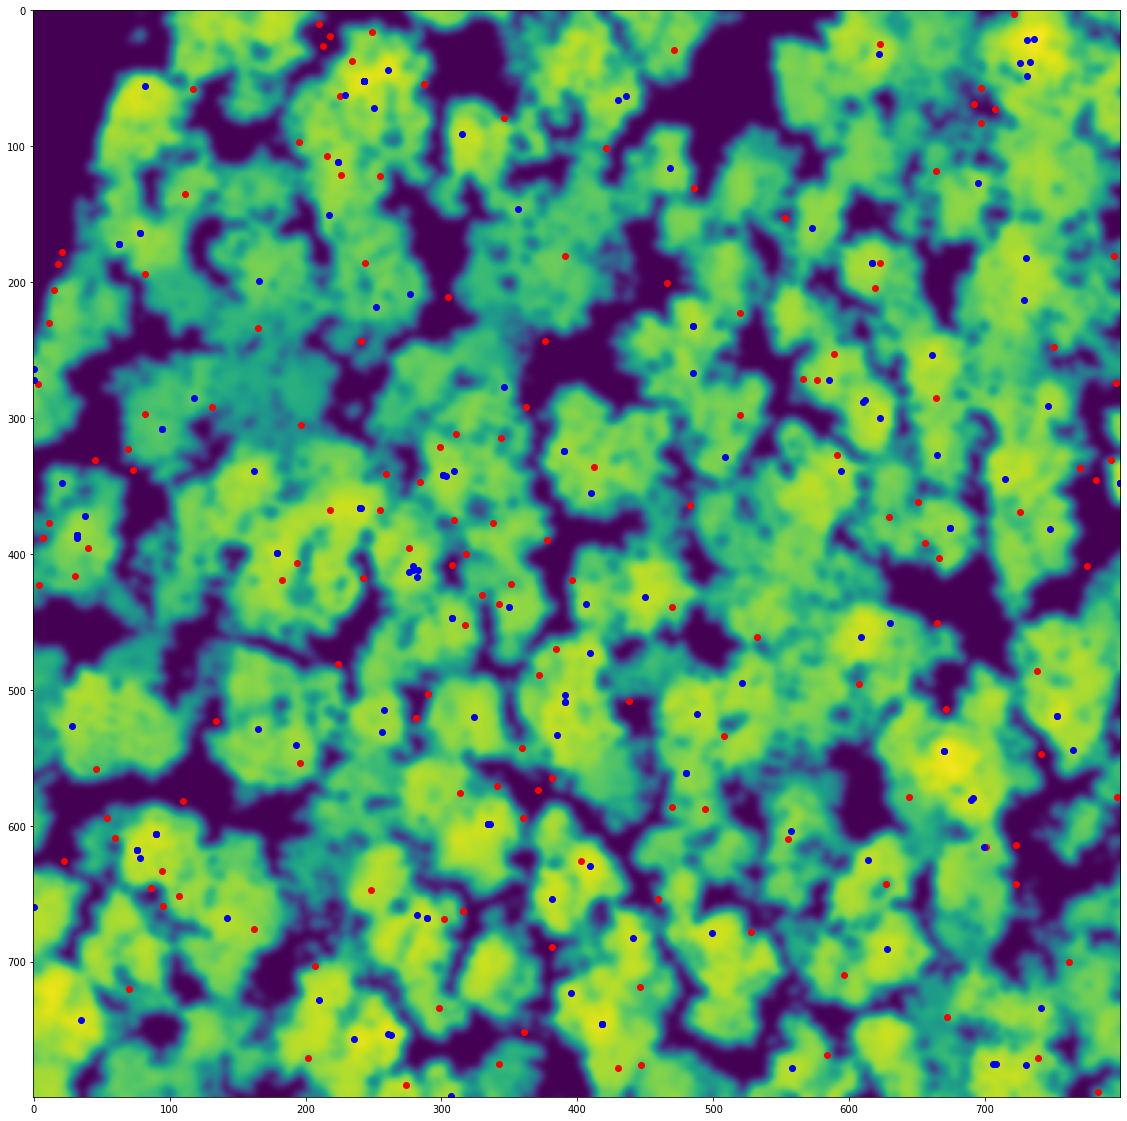

In [12]:
seed2 = seed_2(img_gauss,centroids,patch_size=70)
plt.imshow(img_gauss)
plt.plot(centroids[:, 1], centroids[:, 0], 'ro')
plt.plot(seed2[:, 1], seed2[:, 0], 'bo')

### Step 7: Replace small clusters of seed_2 with single seed. That is our tree top

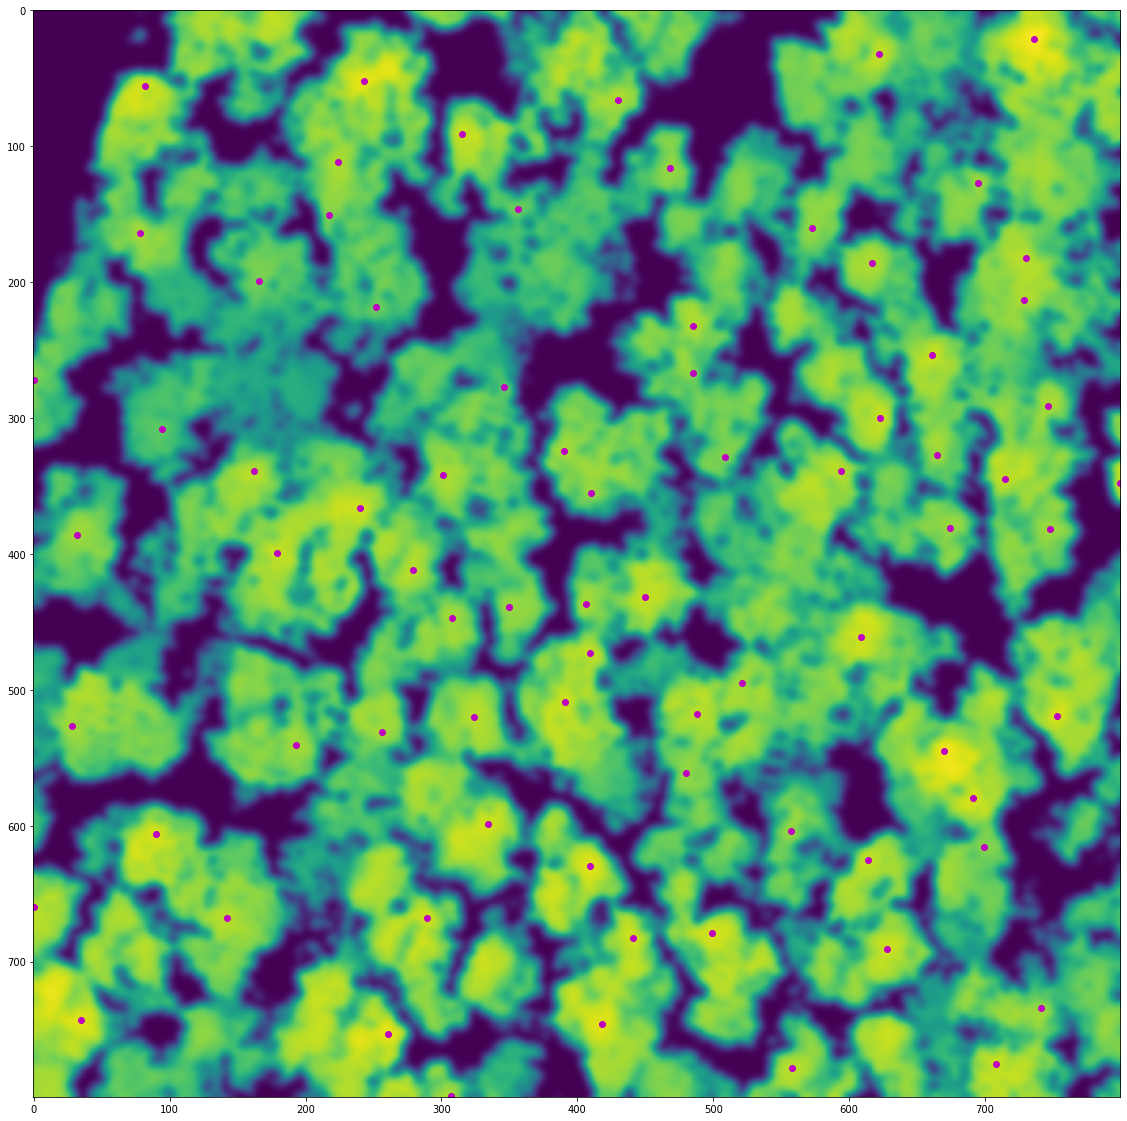

In [13]:
new_cod = new_cod(img_gauss,seed2,patch_size=60)
plt.imshow(img_gauss)
plt.plot(new_cod[:, 1], new_cod[:, 0], 'mo')

# Watershed Segmentation

In [26]:
x = colors.ListedColormap (np.random.rand ( 256,3))

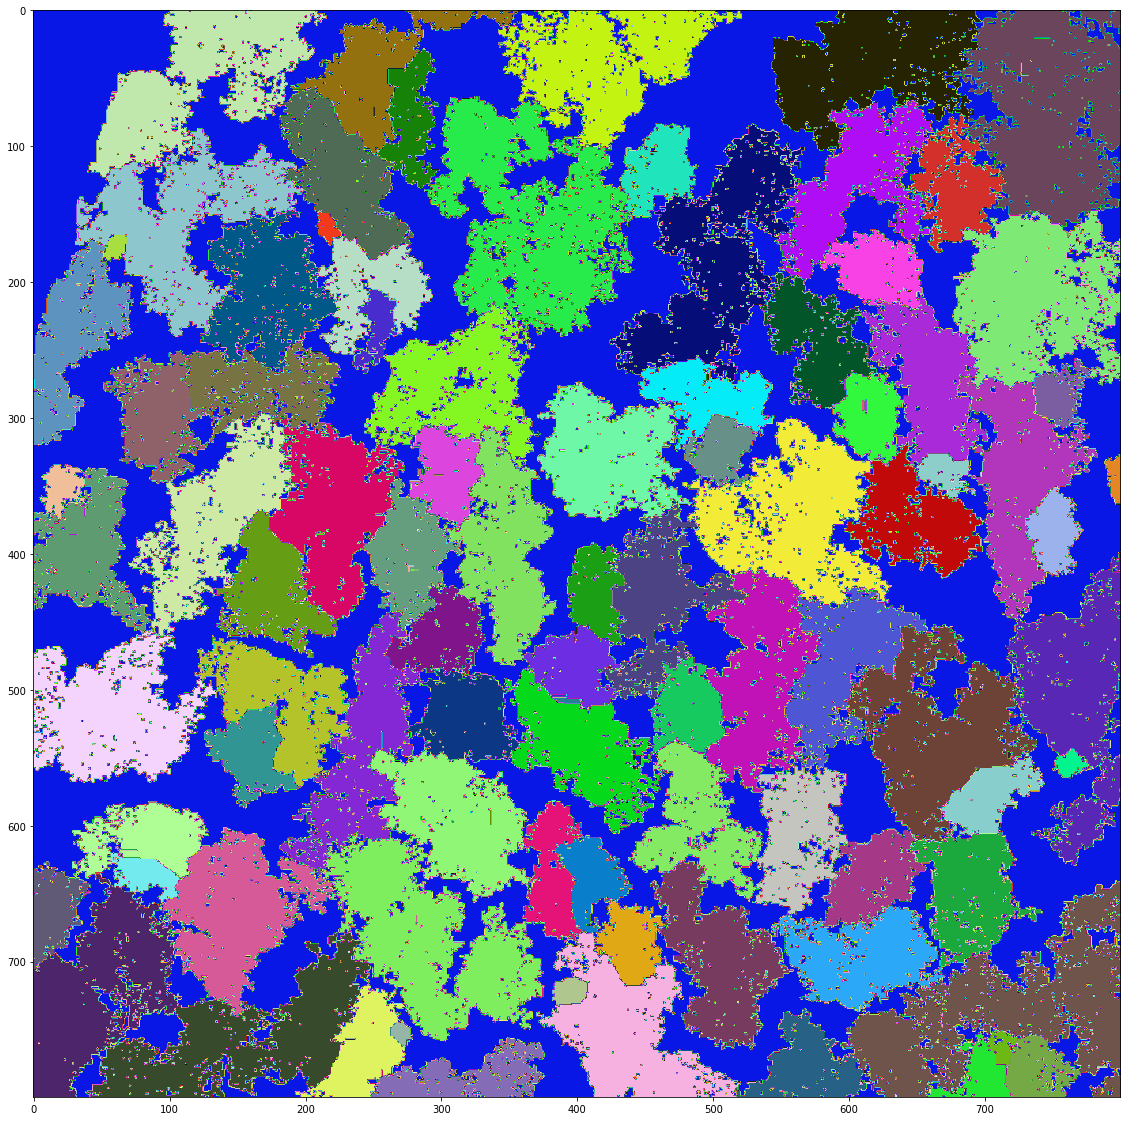

In [27]:
r, thresh = cv2.threshold(data_top,4,255,cv2.THRESH_BINARY)
distance = ndi.distance_transform_edt(thresh)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(seed2.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=thresh)
plt.imshow(labels, cmap=x)

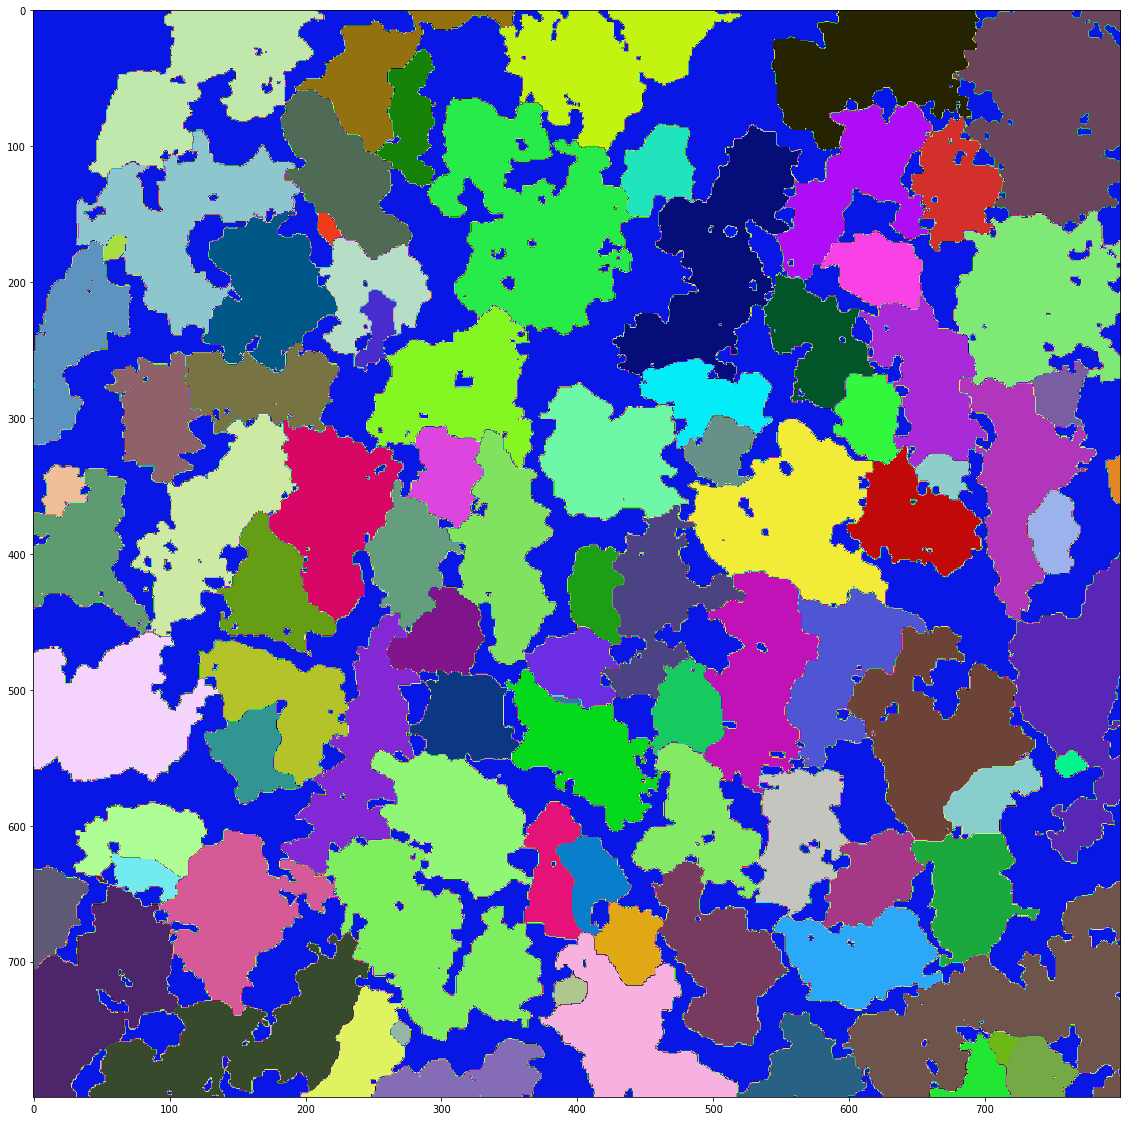

In [28]:
median = filters.median(labels,disk(3))
plt.imshow(median,cmap=x)